# GrowNet (Gradient Boosting Neural Networks)

## What is GrowNet?
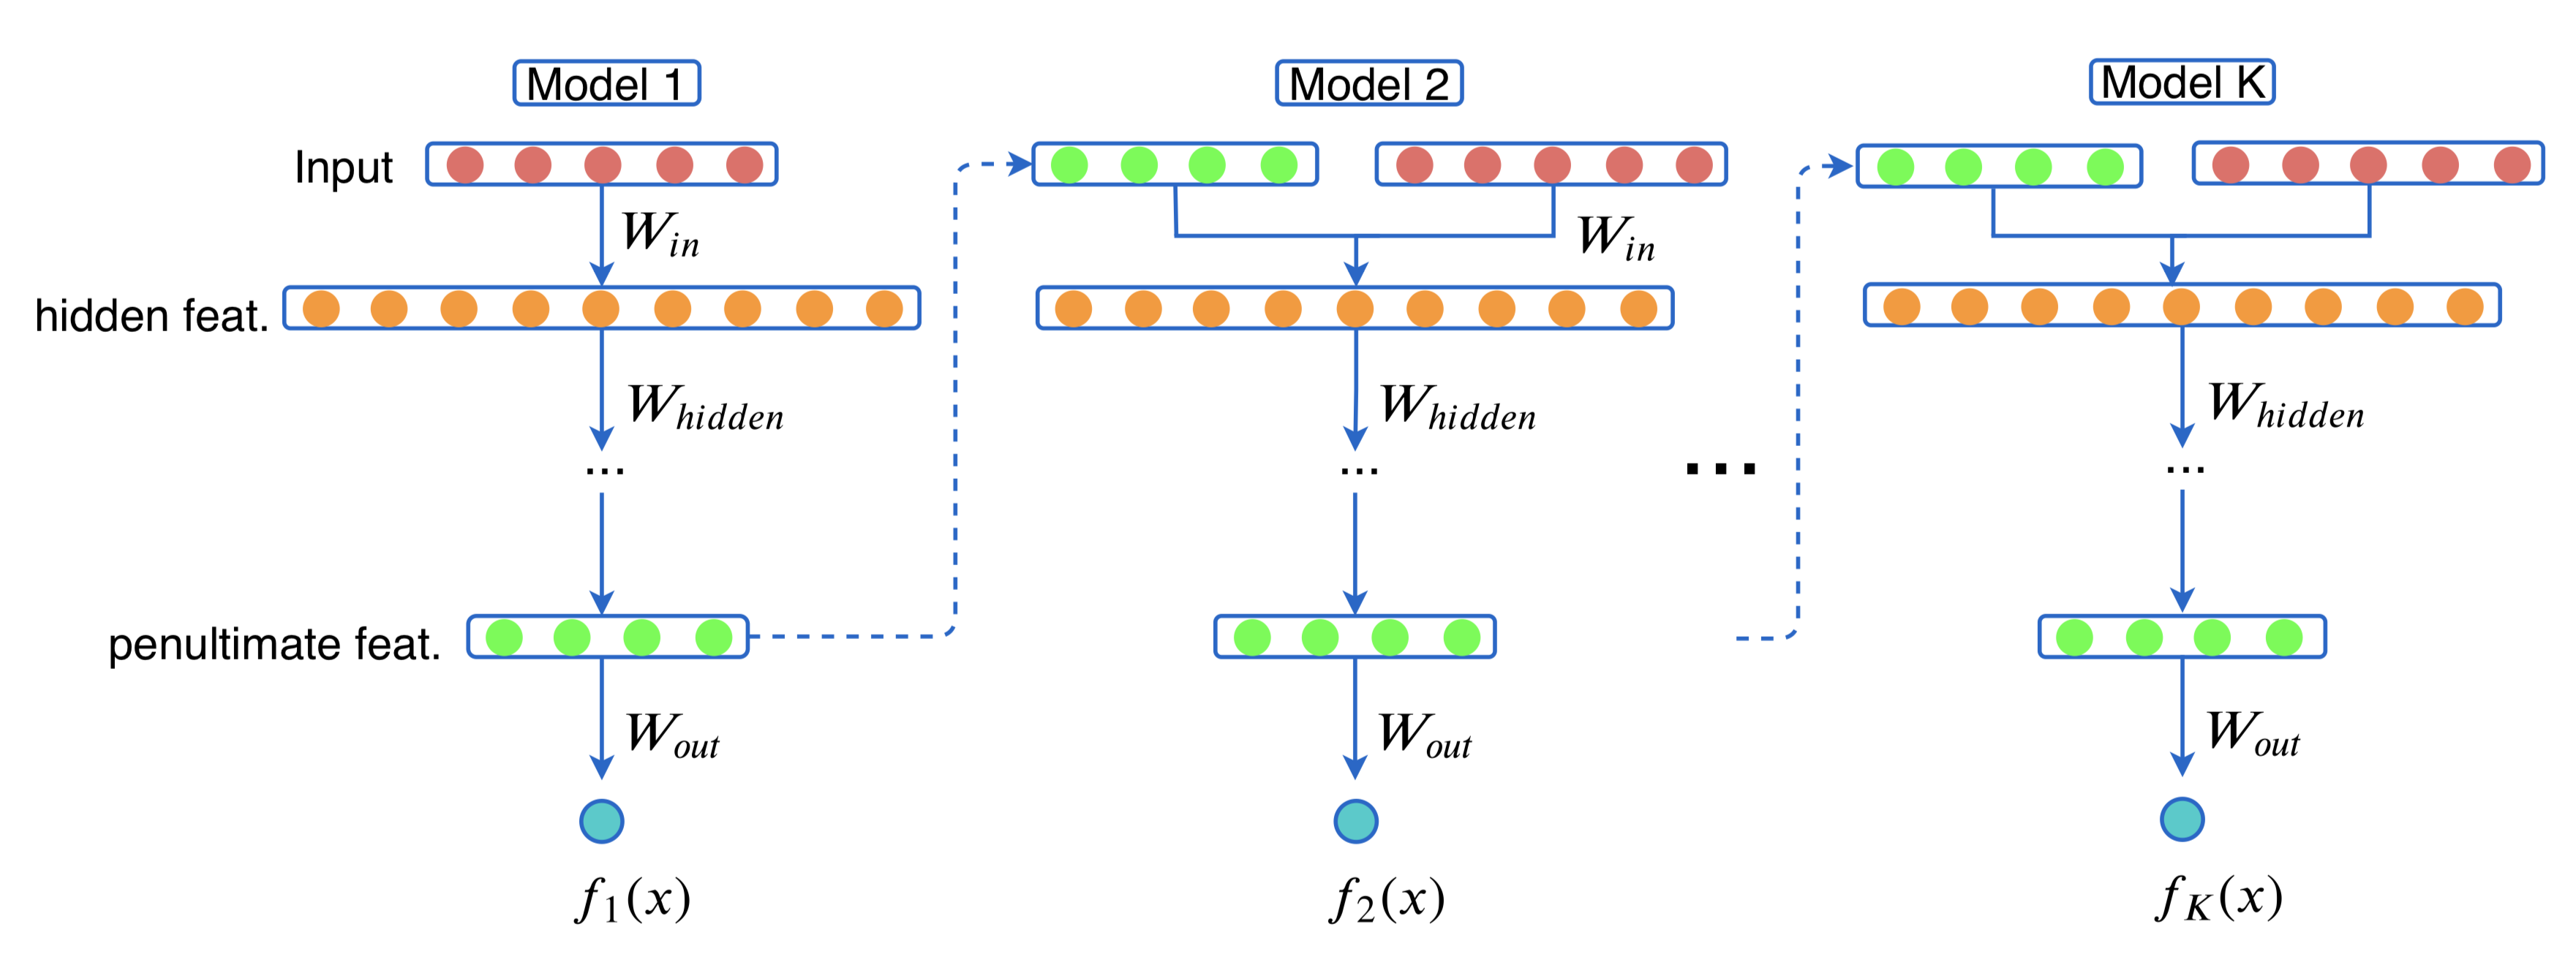

*A novel gradient boosting framework is proposed where shallow neural networks
are employed as “weak learners”. General loss functions are considered under this
unified framework with specific examples presented for classification, regression
and learning to rank. A fully corrective step is incorporated to remedy the pitfall
of greedy function approximation of classic gradient boosting decision tree. The
proposed model rendered outperforming results against state-of-the-art boosting
methods in all three tasks on multiple datasets. An ablation study is performed to
shed light on the effect of each model components and model hyperparameters.*  
(from Abstract part of paper)

The idea of GrowNet is simple.
In contrast to Gradient Boosting Decision Tree (GBDT), Grownet employs Neural Networks as weak learners. 
GrowNet uses the outputs of the previous learners as inputs.
The paper shows GrowNet performed better than XGBoost.

See the links for more details.

github  
https://github.com/sbadirli/GrowNet

arxiv  
https://arxiv.org/pdf/2002.07971

## About this notebook
This notebook introduces an implemention of GrowNet. The implemention is based classification task on github. The original implemention is for one label, but this competition has 206 labels. So I fixed some part of the original implemention.  
I don't do special feature engineering in this notebook because this is just an implemention of GrowNet. What I did is
* put PCA features
* apply label smoothing
* use Chris's new CV strategy  
* use 2 hidden layers NN as a week model  
* clip predictions as postprocessing  

Feel free to add more feature engineerings.

original implemention(PyTorch)  
https://github.com/sbadirli/GrowNet/tree/master/Classification

In this competition, most people say NN performs the best on both CV and LB while other algorisms don't perform as well as NN. So mixture of gradient boosting and NN might be suitable for this task. 

# Import Libraries

In [ ]:
import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer, OneHotEncoder
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import time

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
sample_submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

train_drug = pd.read_csv("../input/lish-moa/train_drug.csv")


# Parameters

In [ ]:
 params = {"n_genes_pca": 50,
          "n_cells_pca": 20,
          "batch_size": 256,
          "lr": 1e-3,
          "weight_decay": 1e-5,
          "n_folds": 5,
          "early_stopping_steps": 5,
          "hidden_size": 512,
          "boost_rate": 1.0,  # original: 1.0
          "num_nets": 20,  # Number of weak NNs. original: 40
          "epochs_per_stage": 1,  # Number of epochs to learn the Kth model. original: 1
          "correct_epoch": 1,    #  Number of epochs to correct the whole week models original: 1
          "model_order": "second"  # You could put "first" according to the original implemention, but error occurs. original: "second"
          }

In [ ]:
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Preprocessing

In [ ]:
# GENES
n_comp = params["n_genes_pca"]

data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[GENES]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(GENES))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [ ]:
#CELLS
n_comp = params["n_cells_pca"]

data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[CELLS]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [ ]:
data = pd.concat([pd.DataFrame(train_features), pd.DataFrame(test_features)])
data2 = pd.get_dummies(data, columns=["cp_time", "cp_dose"])

train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]
# train_features = pd.concat((train_features, train2), axis=1)
# test_features = pd.concat((test_features, test2), axis=1)
train_features = train2
test_features = test2
train_features

In [ ]:
from sklearn.feature_selection import VarianceThreshold


# var_thresh = VarianceThreshold(threshold=0.5)
# data = train_features.append(test_features)
# data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

# train_features_transformed = data_transformed[ : train_features.shape[0]]
# test_features_transformed = data_transformed[-test_features.shape[0] : ]


# train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
#                               columns=['sig_id','cp_type','cp_time','cp_dose'])

# train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)


# test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
#                              columns=['sig_id','cp_type','cp_time','cp_dose'])

# test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)

feature_cols = train_features.columns[4:].tolist()
params["feat_d"] = len(feature_cols)
train_features

In [ ]:
feature_cols[:10]

In [ ]:
train = train_features.merge(train_targets_scored, on='sig_id')
train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

target = train[train_targets_scored.columns]

In [ ]:
train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

In [ ]:
train

In [ ]:
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()

# CV strategy 

In [ ]:
folds_ = train.copy()

folds = []

# LOAD FILES
train_feats = train_features
scored = target
drug = train_drug
# scored = scored.loc[train_feats['cp_type'] == 'trt_cp', :]
drug = drug.loc[train_feats['cp_type'] == 'trt_cp', :]
targets = target_cols
scored = scored.merge(drug, on='sig_id', how='left') 

# LOCATE DRUGS
vc = scored.drug_id.value_counts()
vc1 = vc.loc[vc <= 18].index.sort_values()
vc2 = vc.loc[vc > 18].index.sort_values()

#         vc1 = vc.loc[(vc==6)|(vc==12)|(vc==18)].index.sort_values()
#         vc2 = vc.loc[(vc!=6)&(vc!=12)&(vc!=18)].index.sort_values()
# STRATIFY DRUGS 18X OR LESS
dct1 = {}; dct2 = {}
skf = MultilabelStratifiedKFold(n_splits = params["n_folds"], shuffle = True, random_state = 0)
tmp = scored.groupby('drug_id')[targets].mean().loc[vc1]
for fold,(idxT,idxV) in enumerate(skf.split(tmp,tmp[targets])):
    dd = {k:fold for k in tmp.index[idxV].values}
    dct1.update(dd)

# STRATIFY DRUGS MORE THAN 18X
skf = MultilabelStratifiedKFold(n_splits = params["n_folds"], shuffle = True, random_state = 0)
tmp = scored.loc[scored.drug_id.isin(vc2)].reset_index(drop = True)
for fold,(idxT,idxV) in enumerate(skf.split(tmp,tmp[targets])):
    dd = {k:fold for k in tmp.sig_id[idxV].values}
    dct2.update(dd)

# ASSIGN FOLDS
scored['fold'] = scored.drug_id.map(dct1)
scored.loc[scored.fold.isna(),'fold'] =\
    scored.loc[scored.fold.isna(),'sig_id'].map(dct2)
scored.fold = scored.fold.astype('int8')
folds.append(scored.fold.values)

del scored['fold']

s = np.stack(folds)
train["kfold"] = s.reshape(-1, )

# mskf = MultilabelStratifiedKFold(n_splits=5)

# for f, (t_idx, v_idx) in enumerate(mskf.split(X=train, y=target)):
#     folds.loc[v_idx, 'kfold'] = int(f)

train

# Dataset Classes

In [ ]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :] , dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct

# Dynamic Model

In [ ]:
from enum import Enum
class ForwardType(Enum):
    SIMPLE = 0
    STACKED = 1
    CASCADE = 2
    GRADIENT = 3

class DynamicNet(object):
    def __init__(self, c0, lr):
        self.models = []
        self.c0 = c0
        self.lr = lr
        self.boost_rate  = nn.Parameter(torch.tensor(lr, requires_grad=True, device="cuda"))

    def add(self, model):
        self.models.append(model)

    def parameters(self):
        params = []
        for m in self.models:
            params.extend(m.parameters())

        params.append(self.boost_rate)
        return params

    def zero_grad(self):
        for m in self.models:
            m.zero_grad()

    def to_cuda(self):
        for m in self.models:
            m.cuda()

    def to_eval(self):
        for m in self.models:
            m.eval()

    def to_train(self):
        for m in self.models:
            m.train(True)

    def forward(self, x):
        if len(self.models) == 0:
            batch = x.shape[0]
            c0 = np.repeat(self.c0.detach().cpu().numpy().reshape(1,-1), batch, axis=0)
            return None, torch.Tensor(c0).cuda()
        middle_feat_cum = None
        prediction = None
        with torch.no_grad():
            for m in self.models:
                if middle_feat_cum is None:
                    middle_feat_cum, prediction = m(x, middle_feat_cum)
                else:
                    middle_feat_cum, pred = m(x, middle_feat_cum)
                    prediction += pred
        return middle_feat_cum, self.c0 + self.boost_rate * prediction

    def forward_grad(self, x):
        if len(self.models) == 0:
            batch = x.shape[0]
            c0 = np.repeat(self.c0.detach().cpu().numpy().reshape(1, -1), batch, axis=0)
            return None, torch.Tensor(c0).cuda()
        # at least one model
        middle_feat_cum = None
        prediction = None
        for m in self.models:
            if middle_feat_cum is None:
                middle_feat_cum, prediction = m(x, middle_feat_cum)
            else:
                middle_feat_cum, pred = m(x, middle_feat_cum)
                prediction += pred
        return middle_feat_cum, self.c0 + self.boost_rate * prediction

    @classmethod
    def from_file(cls, path, builder):
        d = torch.load(path)
        net = DynamicNet(d['c0'], d['lr'])
        net.boost_rate = d['boost_rate']
        for stage, m in enumerate(d['models']):
            submod = builder(stage)
            submod.load_state_dict(m)
            net.add(submod)
        return net

    def to_file(self, path):
        models = [m.state_dict() for m in self.models]
        d = {'models': models, 'c0': self.c0, 'lr': self.lr, 'boost_rate': self.boost_rate}
        torch.save(d, path)

# Weak Models

In [ ]:
class MLP_1HL(nn.Module):
    def __init__(self, dim_in, dim_hidden1, dim_hidden2, sparse=False, bn=True):
        super(MLP_1HL, self).__init__()
#         self.in_layer = nn.Linear(dim_in, dim_hidden1)
#         self.out_layer = nn.Linear(dim_hidden1, 206)
#         self.lrelu = nn.LeakyReLU(0.1)
#         self.relu = nn.ReLU()
        self.layer1 = nn.Sequential(
                        nn.Dropout(0.2),
                        nn.Linear(dim_in, dim_hidden1),
                        )
        self.layer2 = nn.Sequential(
                        nn.ReLU(),
#                         nn.BatchNorm1d(dim_hidden1),
#                         nn.Dropout(0.4),
                        nn.Linear(dim_hidden1, 206))
        if bn:
            self.bn = nn.BatchNorm1d(dim_hidden1)
            self.bn2 = nn.BatchNorm1d(dim_in)

    def forward(self, x, lower_f):
        if lower_f is not None:
            x = torch.cat([x, lower_f], dim=1)
            x = self.bn2(x)
        out = self.layer1(x)
        return out, self.layer2(out)

    @classmethod
    def get_model(cls, stage, params):
        if stage == 0:
            dim_in = params["feat_d"]
        else:
            dim_in = params["feat_d"] + params["hidden_size"]
        model = MLP_1HL(dim_in, params["hidden_size"], params["hidden_size"])
        return model


class MLP_2HL(nn.Module):
    def __init__(self, dim_in, dim_hidden1, dim_hidden2, sparse=False, bn=True):
        super(MLP_2HL, self).__init__()
        # self.in_layer = SpLinear(dim_in, dim_hidden1) if sparse else nn.Linear(dim_in, dim_hidden1)
        # self.dropout_layer = nn.Dropout(0.4)
        # self.lrelu = nn.LeakyReLU(0.1)
        # self.relu = nn.ReLU()
        # self.hidden_layer = nn.Linear(dim_hidden1, dim_hidden2)
        # self.out_layer = nn.Linear(dim_hidden2, 206)
        # self.bn = nn.BatchNorm1d(dim_hidden1)
        self.bn2 = nn.BatchNorm1d(dim_in)

        self.layer1 = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(dim_in, dim_hidden1),
            nn.ReLU(),
            nn.BatchNorm1d(dim_hidden1),
            nn.Dropout(0.4),
            nn.Linear(dim_hidden1, dim_hidden2)
        )
        self.layer2 = nn.Sequential(
            nn.ReLU(),
#             nn.Dropout(0.4),
            nn.Linear(dim_hidden2, 206)
        )

    def forward(self, x, lower_f):
        if lower_f is not None:
            x = torch.cat([x, lower_f], dim=1)
            x = self.bn2(x)
        # out = self.lrelu(self.in_layer(x))
        # out = self.bn(out)
        # out = self.hidden_layer(out)
        middle_feat = self.layer1(x)
        out = self.layer2(middle_feat)
        return middle_feat, out

    @classmethod
    def get_model(cls, stage, params):
        if stage == 0:
            dim_in = params["feat_d"]
        else:
            dim_in = params["feat_d"] + params["hidden_size"]
        model = MLP_2HL(dim_in, params["hidden_size"], params["hidden_size"])
        return model

In [ ]:
from torch.nn.modules.loss import _WeightedLoss
class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [ ]:
def get_optim(params, lr, weight_decay):
    optimizer = optim.Adam(params, lr, weight_decay=weight_decay)
    #optimizer = SGD(params, lr, weight_decay=weight_decay)
    return optimizer

def logloss(net_ensemble, test_loader):
    loss = 0
    total = 0
    loss_f = nn.BCEWithLogitsLoss() # Binary cross entopy loss with logits, reduction=mean by default
    for data in test_loader:
        x = data["x"].cuda()
        y = data["y"].cuda()
        # y = (y + 1) / 2
        with torch.no_grad():
            _, out = net_ensemble.forward(x)
        # out = torch.as_tensor(out, dtype=torch.float32).cuda().view(-1, 1)
        loss += loss_f(out, y)
        total += 1

    return loss / total


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Training

In [ ]:
c0_ = np.log(np.mean(train_targets_scored.iloc[:, 1:].values, axis=0))
def train_fn(seed=0):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    
    for fold in range(params["n_folds"]):
        seed_everything(seed)
        
        train_idx = train[train["kfold"] != fold].index
        val_idx = train[train["kfold"] == fold].index
        
        train_df = train[train["kfold"] != fold].reset_index(drop=True)
        val_df = train[train["kfold"] == fold].reset_index(drop=True)
        
        x_train = train_df[feature_cols].values
        y_train = train_df[target_cols].values  #
        
        x_val = val_df[feature_cols].values  #
        y_val = val_df[target_cols].values  #
        
        train_ds = MoADataset(x_train, y_train)
        val_ds = MoADataset(x_val, y_val)
        train_loader = DataLoader(train_ds, batch_size=params["batch_size"], shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=params["batch_size"], shuffle=False)
        
        best_score = np.inf
        val_score = best_score
        best_stage = params["num_nets"] - 1

        c0 = torch.tensor(c0_, dtype=torch.float).to(device)
        net_ensemble = DynamicNet(c0, params["boost_rate"])
        loss_f1 = nn.MSELoss(reduction='none')
#         loss_f2 = nn.BCEWithLogitsLoss(reduction='none')
        loss_f2 = SmoothBCEwLogits(smoothing=0.001, reduction="none")
        loss_models = torch.zeros((params["num_nets"], 3))

        all_ensm_losses = []
        all_ensm_losses_te = []
        all_mdl_losses = []
        dynamic_br = []

        lr = params["lr"]
        L2 = params["weight_decay"]        
        
        early_stop = 0
        for stage in range(params["num_nets"]):
            t0 = time.time()
            #### Higgs 100K, 1M , 10M experiment: Subsampling the data each model training time ############
            # indices = list(range(len(train)))
            # split = 1000000
            # indices = sklearn.utils.shuffle(indices, random_state=41)
            # train_idx = indices[:split]
            # train_sampler = SubsetRandomSampler(train_idx)
            # train_loader = DataLoader(train, opt.batch_size, sampler = train_sampler, drop_last=True, num_workers=2)
            ################################################################################################

            model = MLP_2HL.get_model(stage, params)  # Initialize the model_k: f_k(x), multilayer perception v2
            model.to(device)



            optimizer = get_optim(model.parameters(), lr, L2)
            net_ensemble.to_train() # Set the models in ensemble net to train mode
            stage_mdlloss = []
            for epoch in range(params["epochs_per_stage"]):
                for i, data in enumerate(train_loader):
                    x = data["x"].to(device)
                    y = data["y"].to(device)
                    middle_feat, out = net_ensemble.forward(x)
                    # out = torch.as_tensor(out, dtype=torch.float32).cuda().view(-1, 1)
                    if params["model_order"] == 'first':
                        grad_direction = y / (1.0 + torch.exp(y * out))
                    else:
                        h = 1 / ((1 + torch.exp(y * out)) * (1 + torch.exp(-y * out)))
                        grad_direction = y * (1.0 + torch.exp(-y * out))
                        # out = torch.as_tensor(out)
                        nwtn_weights = (torch.exp(out) + torch.exp(-out)).abs()
                    _, out = model(x, middle_feat)
                    # out = torch.as_tensor(out, dtype=torch.float32).cuda().view(-1, 1)
                    loss = loss_f1(net_ensemble.boost_rate * out, grad_direction)  # T
                    loss = loss * h
                    loss = loss.mean()
                    model.zero_grad()
                    loss.backward()
                    optimizer.step()
                    stage_mdlloss.append(loss.item()) 
                    

            net_ensemble.add(model)
            sml = np.mean(stage_mdlloss)


            stage_loss = []
            lr_scaler = 2
            # fully-corrective step
            if stage != 0:
                # Adjusting corrective step learning rate 
                if stage % 3 == 0:
                    #lr_scaler *= 2
                    lr /= 2
                    # L2 /= 2
                optimizer = get_optim(net_ensemble.parameters(), lr / lr_scaler, L2)
                for _ in range(params["correct_epoch"]):
                    for i, data in enumerate(train_loader):
                        x = data["x"].to(device)
                        y = data["y"].to(device)

                        _, out = net_ensemble.forward_grad(x)
                        # out = torch.as_tensor(out, dtype=torch.float32).cuda().view(-1, 1)
                        # y = (y + 1.0) / 2.0
                        loss = loss_f2(out, y).mean() 
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        stage_loss.append(loss.item())
                        

            
            sl_te = logloss(net_ensemble, val_loader)  # -----
            # Store dynamic boost rate
            dynamic_br.append(net_ensemble.boost_rate.item())
            # store model
            # net_ensemble.to_file(f"./{fold}FOLD_{seed}_.pth")
            # net_ensemble = DynamicNet.from_file(f"./{fold}FOLD_{seed}_.pth", lambda stage: MLP_2HL.get_model(stage, self.params))

            elapsed_tr = time.time()-t0
            sl = 0
            if stage_loss != []:
                sl = np.mean(stage_loss)

            

            all_ensm_losses.append(sl)
            all_ensm_losses_te.append(sl_te)
            all_mdl_losses.append(sml)
            print(f'Stage - {stage}, training time: {elapsed_tr: .1f} sec, boost rate: {net_ensemble.boost_rate: .4f}, Training Loss: {sl: .5f}, Val Loss: {sl_te: .5f}')


            net_ensemble.to_cuda()
            net_ensemble.to_eval() # Set the models in ensemble net to eval mode

            # Train
            # print('Acc results from stage := ' + str(stage) + '\n')
            # AUC
#             val_score = auc_score(net_ensemble, val_loader) 
            if sl_te < best_score:
                best_score = sl_te
                best_stage = stage
                net_ensemble.to_file(f"./{fold}FOLD_{seed}_.pth")
                early_stop = 0
            else:
                
                early_stop += 1
                

#             test_score = auc_score(net_ensemble, val_loader)
#             print(f'Stage: {stage}, AUC@Val: {val_score:.4f}, AUC@Test: {test_score:.4f}')

#             loss_models[stage, 1], loss_models[stage, 2] = val_score, test_score
            
    
            if early_stop > params["early_stopping_steps"]:
                print("early stopped!")
                break

#         val_auc, te_auc = loss_models[best_stage, 1], loss_models[best_stage, 2]
        print(f'Best validation stage: {best_stage}')

        net_ensemble = DynamicNet.from_file(f"./{fold}FOLD_{seed}_.pth", lambda stage: MLP_2HL.get_model(stage, params))
        net_ensemble.to_cuda()
        net_ensemble.to_eval()

        preds = []
        with torch.no_grad():
            for data in val_loader:
                x = data["x"].to(device)
                _, pred = net_ensemble.forward(x)
                preds.append(pred.sigmoid().detach().cpu().numpy())
        oof[val_idx, :] = np.concatenate(preds)

        x_test = test[feature_cols].values
        test_ds = TestDataset(x_test)
        test_loader = DataLoader(test_ds, batch_size=params["batch_size"], shuffle=False)

        preds = []
        with torch.no_grad():
            for data in test_loader:
                x = data["x"].to(device)
                _, pred = net_ensemble.forward(x)
                preds.append(pred.sigmoid().detach().cpu().numpy())
        predictions += np.concatenate(preds) / params["n_folds"]
        
    oof = np.clip(oof, 1e-3, 1 - 1e-3)
    predictions = np.clip(predictions, 1e-3, 1 - 1e-3)


    train[target_cols] = oof
    test[target_cols] = predictions

    val_results = train_targets_scored.drop(columns=target_cols).merge(train[["sig_id"] + target_cols], on="sig_id", how="left").fillna(0)

    y_true = train_targets_scored[target_cols].values
    y_pred = val_results[target_cols].values

    score = 0
    for i in range(len(target_cols)):
        score_ = log_loss(y_true[:, i], y_pred[:, i])
        score += score_ / len(target_cols)
#     score = score
    print("CV log_loss ", score)

    sub = sample_submission
    sub = sub.drop(columns=target_cols).merge(test[["sig_id"]+target_cols], on="sig_id", how="left").fillna(0)

#         sub = sub.drop(columns=self.target_cols).merge(test_[["sig_id"]+self.target_cols+["cp_time_24", "cp_dose_D2"]], on="sig_id", how="left").fillna(0)
#         sub.loc[:, ["atp-sensitive_potassium_channel_antagonist", "erbb2_inhibitor"]] = 0.000012
#         sub = sub.drop(["cp_time_24", "cp_dose_D2"], axis=1)
    return sub

In [ ]:
sub = train_fn()

In [ ]:
sub

# Submission

In [ ]:
sub.to_csv("submission.csv", index=False)